# Getting the optimal local Fourier approximation for MV-SDE

add description here

### Initialising libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

## McKean-Vlasov SDE of Kuramoto's type.

### We put here the function to simulate the Brownian motion.

In [2]:
def simulate_dW(N,T):
    return np.random.normal(size= N, scale = np.sqrt(T/N[1]))

def simulate_dW_1d(N,T):
    return np.random.normal(size = N, scale = np.sqrt(T/N))

### We initialise the main class.

We initialise the class of MV-SDE that admits the following dynamics:

$$
\text{d}X_t = \mathbb{E}[\sin(X_t-x)]_{\big|x = X_t}~\text{d}t + \sigma ~\text{d}W_t, \quad X_0 = x_0 \in L_2(\Omega).
$$

The drift can be equivalently rewritten as

$$
\mathbb{E}[\sin(X_t)] \cos(X_t) - \mathbb{E}[\cos(X_t)] \sin(X_t).
$$

In [3]:
class SDE_Kuramoto_MV ():
    
    #### Check the correct passing of the arguments
    
    def __init__(self, x_0 = 0, sigma = 1, dW_t = simulate_dW((100,100),1),
                 T = 1, n_discr = 100, n_part = 100):
        self.x_0 = np.random.normal(size = n_part, scale = 0.2)
        self.sigma = sigma
        self.T = T
        self.n_discr = n_discr
        self.n_part = n_part
        self.dt = self.T / self.n_discr
        self.dW_t = dW_t
        self.x = self.get_path()
        
    #### Simulates the path according to Euler algorithm    
    def get_path(self):
        x = np.zeros((self.n_part,self.n_discr))
        
        sum_sin = 0
        sum_cos = 0
        
        for j in range(self.n_part):
            x[j][0] = self.x_0[j]
            sum_sin += np.sin(x[j][0])
            sum_cos += np.cos(x[j][0])
        aver_sin = sum_sin / self.n_part
        aver_cos = sum_cos / self.n_part
        
        for i in range(1,self.n_discr):
            for j in range(self.n_part):
                
                x[j][i] = x[j][i - 1] + (np.cos(x[j][i - 1]) * aver_sin 
                                      - np.sin(x[j][i - 1]) * aver_cos) * self.dt + self.sigma * self.dW_t[j][i - 1]
                sum_sin += np.sin(x[j][i])
                sum_cos += np.cos(x[j][i])
            
            aver_sin = sum_sin / self.n_part
            aver_cos = sum_cos / self.n_part
            
            aver_sin
            
            sum_sin = 0
            sum_cos = 0
        return x
    
    #### Plots the path
    def plot_path(self):
        t = np.linspace(0, self.T, self.n_discr)
        
        fig, ax = plt.subplots(1,1,figsize=(15, 10), tight_layout=True)

        ax.set_title(r"Dynamics of the SDE", fontsize = 15)
        ax.set_xlabel(r'$t$',fontsize = 15)
        ax.set_ylabel(r'$X_t$',fontsize = 15)
        ax.tick_params(axis='both', which='major', labelsize = 20)
        ax.tick_params(axis='both', which='minor', labelsize = 20)
        for i in range(self.n_part):
            ax.plot(t, self.x[i][:])
        #ax.plot(t,[0]*t.shape[0],label = 'asymptote')
        plt.show()

        #ksi = self.get_path_for_gradient_SDE()

### Testing the class.

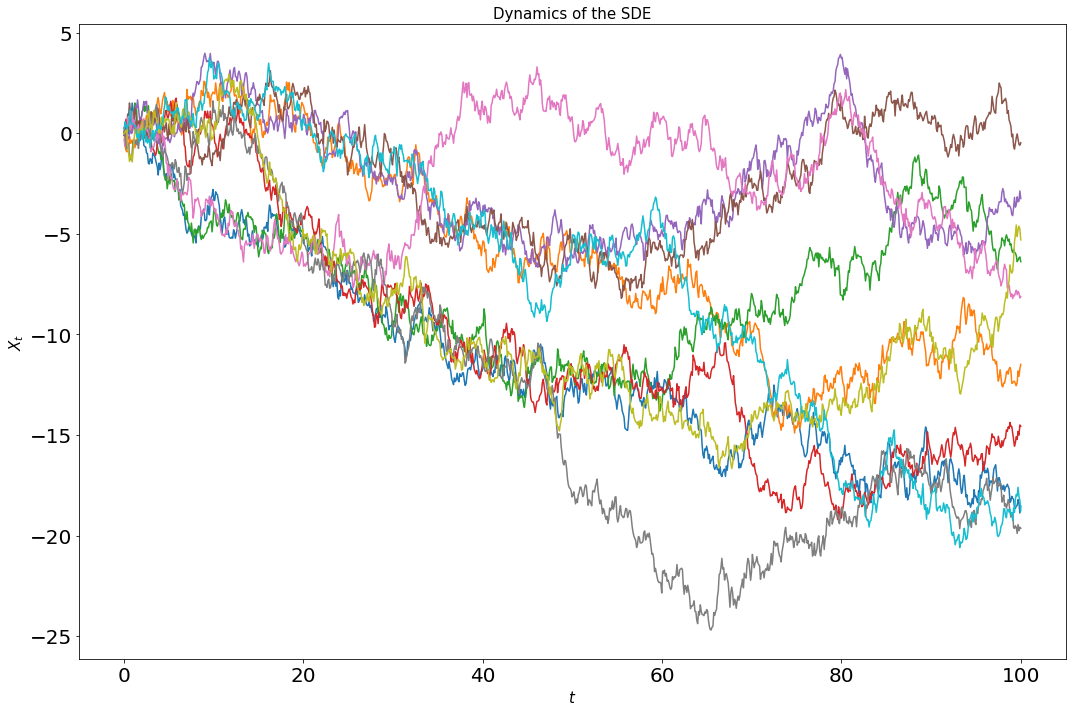

In [4]:
# Discretisation step to render the SDE and Gamma

# Initialise the number of Euler discretisation steps and time horizon
n_discr = 1000
T = 100
dt = T / n_discr

# Initialise the number of particles
n_part = 10

# Initialise the starting value and diffusion constant
x_0 = 1
sigma = 1

# Get the Wiener increments
dW_t = simulate_dW((n_part,n_discr),T)

# Initialise the class and render the dynamics
X = SDE_Kuramoto_MV(x_0, sigma, dW_t, T, n_discr, n_part)
X.plot_path()

## The approximation of MV-SDE's of Kuramoto type.

In [5]:
class SDE_Kuramoto_appr ():
    
    ### Check the correct passing of the arguments
    
    def __init__(self, x_0 = 0, sigma = 1, 
                 gamma = np.random.uniform(low = -1, high = 1, size = (2,100)), 
                 dW_t = simulate_dW_1d(100,1),  T = 1, n_discr = 100):
        self.x_0 = x_0
        self.sigma = sigma
        self.T = T
        self.n_discr = n_discr
        self.dt = self.T / self.n_discr
        self.gamma = gamma
        self.dW_t = dW_t
        self.x = self.get_path()
        self.ksi = self.get_path_for_gradient_SDE(k = 0, n = 0)
        
        
    #### Simulates the path according to Euler algorithm    
    def get_path(self):
        x = np.zeros(self.n_discr)
        x[0] = self.x_0 
        for i in range(1,self.n_discr):

            x[i] = x[i - 1] + (self.gamma[0][i - 1] * np.sin(x[i - 1]) - self.gamma[1][i - 1] * np.cos(x[i - 1])) * self.dt + self.sigma * self.dW_t[i - 1]
        return x

    #############
#############

#######DOUBLE CHECK FOR SIN VS COS

############
############

    def get_path_for_gradient_SDE(self,k,n):
        ksi = np.zeros(self.n_discr)
        for i in range(1,self.n_discr):
            ## check if i == n or n + 1
            if k == 0:
                if (i == n):
                    ksi[i] = ksi[i - 1] + (np.sin(self.x[i - 1]) + 
                                                 self.gamma[0][i - 1] * np.cos(self.x[i - 1]) * ksi[i - 1] + 
                                                 self.gamma[1][i - 1] * np.sin(self.x[i - 1]) * ksi[i - 1]) * self.dt + self.sigma * self.dW_t[i - 1] 
                elif (i != n):
                    ksi[i] = ksi[i - 1] + (self.gamma[0][i - 1] * np.cos(self.x[i - 1]) * ksi[i - 1] + 
                                                 self.gamma[1][i - 1] * np.sin(self.x[i - 1]) * ksi[i - 1]) * self.dt + self.sigma * self.dW_t[i - 1]
            ### CHECK the signs 
            
            elif k == 1:
                if (i == n):
                    ksi[i] = ksi[i - 1] + (-np.cos(self.x[i - 1]) + 
                                                     self.gamma[0][i - 1] * np.cos(self.x[i - 1]) * ksi[i - 1] + 
                                                     self.gamma[1][i - 1] * np.sin(self.x[i - 1]) * ksi[i - 1]) * self.dt + self.sigma * self.dW_t[i - 1]   
                elif (i != n):
                    ksi[i] = ksi[i - 1] + (self.gamma[0][i - 1] * np.cos(self.x[i - 1]) * ksi[i - 1] + 
                                                 self.gamma[1][i - 1] * np.sin(self.x[i - 1]) * ksi[i - 1]) * self.dt + self.sigma * self.dW_t[i - 1]
        return ksi
    
    #### Plots the path
    def plot_path(self):
        t = np.linspace(0, self.T, self.n_discr)
        
        fig, ax = plt.subplots(1,1,figsize=(15, 10), tight_layout=True)

        ax.set_title(r"Dynamics of the SDE", fontsize = 15)
        ax.set_xlabel(r'$t$',fontsize=15)
        ax.set_ylabel(r'$X_t$',fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize = 20)
        ax.tick_params(axis='both', which='minor', labelsize = 20)
        ax.plot(t, self.x)
        ax.plot(t, self.ksi)
        #ax.plot(t, self.ksi[1])
        plt.show()
        
    def plot_grad_path(self):
        t = np.linspace(0, self.T, self.n_discr)
        
        fig, ax = plt.subplots(1,1,figsize=(15, 10), tight_layout=True)

        ax.set_title(r"Dynamics of the gradient SDE", fontsize = 15)
        ax.set_xlabel(r'$t$',fontsize=15)
        ax.set_ylabel(r'$\xi_t$',fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize = 20)
        ax.tick_params(axis='both', which='minor', labelsize = 20)
        ax.plot(t, self.ksi[0])
        
        plt.show()
        
    def update_gamma(self, gamma):
        self.gamma = gamma
        x = self.get_path()
        #ksi = self.get_path_for_gradient_SDE()

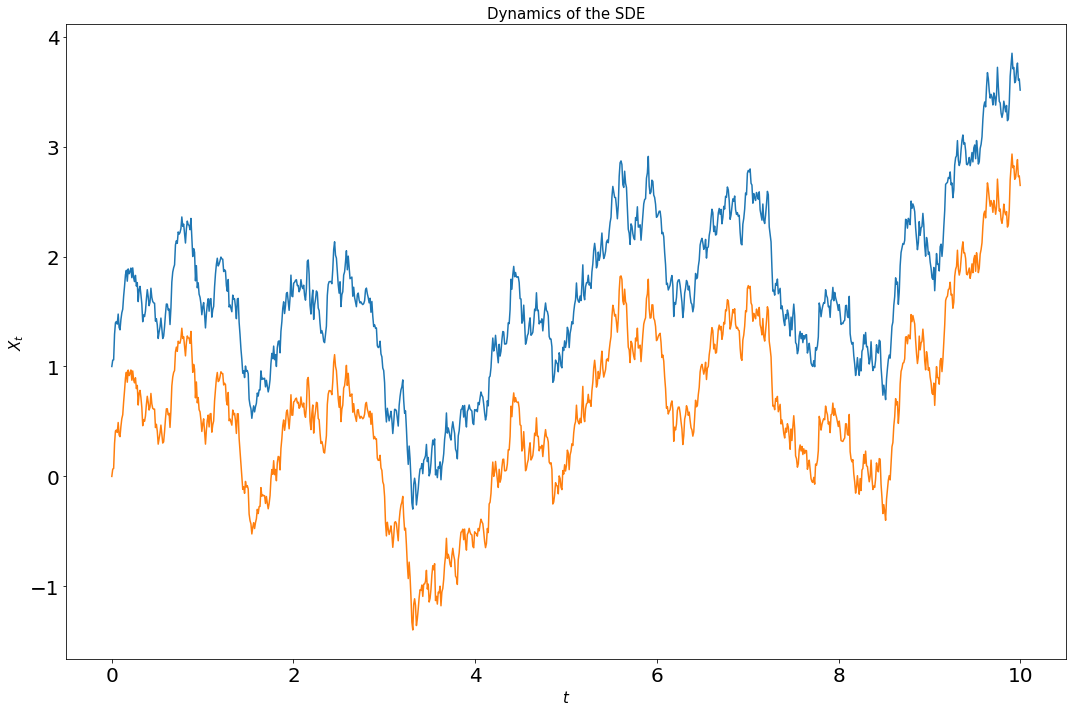

In [6]:
# Discretisation step to render the SDE and Gamma

# Initialise the number of Euler discretisation steps and time horizon

n_discr = 1000
T = 10
dt = T / n_discr


# Initialise the starting value, drift function, starting guess for gamma and diffusion constant
x_0 = 1

gamma = np.random.uniform(low = - 1, high = 1, size = (2,n_discr))
sigma = 1

# Get the Wiener increments
dW_t = simulate_dW_1d(n_discr,T)

# Initialise the class and render the dynamics
X = SDE_Kuramoto_appr(x_0, sigma, gamma, dW_t, T, n_discr)
X.plot_path()
#X.plot_grad_path()

dW_t = simulate_dW((1,n_discr),T)

## Algorithm

We introduce the function that implements the algorithm.

In [26]:
eta = 0.01
N_iter = 100

# Initialise the number of Euler discretisation steps and time horizon

n_discr = 30
T = 1
dt = T / n_discr

# Initialise the starting value, starting guess for gamma and diffusion constant

x_0 = 1
gamma = np.random.uniform(low = - 0.7, high = 0.7, size = (2,n_discr))
#print(f'Starting gamma is {gamma}.')

def SGD_MV(n_discr, eta, gamma, T, eps, N_iter):
    t_0 = time.time()
    gamma_aver = 0
    i = 0
    err = np.inf
    
    while (err > eps) and (i < N_iter):

        dW_t_1 = simulate_dW_1d(n_discr,T)
        dW_t_2 = simulate_dW_1d(n_discr,T)
        X_1 = SDE_Kuramoto_appr(x_0, sigma, gamma, dW_t_1, T, n_discr)
        X_2 = SDE_Kuramoto_appr(x_0, sigma, gamma, dW_t_2, T, n_discr)

        grad_first_part = np.zeros((2,n_discr))
        grad_first_part[0] = 2 * (np.sin(X_1.x) - gamma[0])
        grad_first_part[1] = 2 * (-np.cos(X_1.x) - gamma[1])
        grad_first_part = grad_first_part.reshape(2 * n_discr)

        jacobian = np.zeros((2 * n_discr, 2 * n_discr))

        for i_1 in range(n_discr):
            for k_1 in range(2):
                for i_2 in range(n_discr):
                    for k_2 in range(2):
                        if k_1 == 0:
                            jacobian[k_1 * n_discr + i_1][k_2 * n_discr + i_2] = np.cos(X_2.x[i_1]) * X_2.get_path_for_gradient_SDE(k_2,i_2)[i_1] - (i_1 == i_2 and k_1 == k_2)
                        elif k_1 == 1:
                            jacobian[k_1 * n_discr + i_1][k_2 * n_discr + i_2] = np.sin(X_2.x[i_1]) * X_2.get_path_for_gradient_SDE(k_2,i_2)[i_1] - (i_1 == i_2 and k_1 == k_2)

        ### Save Jacobian as a tensor?

        gamma = gamma.reshape(2 * n_discr)
        #print(gamma.shape)
        gamma = gamma - eta * np.matmul(grad_first_part,jacobian)
        gamma = gamma.reshape(2,n_discr)
        #print(gamma.shape)
        i += 1
    # ToDo: save the gamma for later to calculate the weighted average further on 
    
        gamma_aver = i / (i + 1) * gamma_aver + 1 / (i + 1) * gamma
        #print(f'Gamma average for {i} iteration is: \n {gamma_aver}')
        #print(f'Step {i} completed.')
        if ((i+1) % (N_iter // 10))  == 0 and (time.time() - t_0 > 60):
            print(f'|{((i+1) // (N_iter // 10))*10}% of the iterations completed.|')
    
    print(f'The solution of the SGD algorithm is {gamma_aver}.')
    print(f'Solved for {time.time() - t_0:.{4}} seconds.')
    return gamma_aver

# n_discr = 30
# T = 1
# dt = T / n_discr
# eta = 0.01
# x_0 = 1
# sigma = 1
# gamma = np.random.uniform(low = - 0.7, high = 0.7, size = (2,n_discr))
# eps = 0
# N_iter = 1000

# gamma_aver = SGD_MV(n_discr, eta, gamma, T, eps, N_iter)

The solution of the SGD algorithm is [[ 0.81745129  0.79990013  0.79637648  0.854642    0.81896715  0.81746178
   0.78269862  0.77322485  0.75928492  0.77315448  0.76530572  0.77206745
   0.72440394  0.75913896  0.73064653  0.68739085  0.71415421  0.70391164
   0.69244718  0.62527259  0.65528681  0.59611666  0.61988424  0.61687809
   0.61602167  0.62001316  0.55386124  0.59131469  0.5456305   0.52093696]
 [-0.51054361 -0.45665163 -0.45874817 -0.39722341 -0.37208195 -0.34812195
  -0.30702684 -0.30270368 -0.31311503 -0.27668898 -0.2111663  -0.21678094
  -0.1676947  -0.17145434 -0.12132777 -0.13207656 -0.10149773 -0.09744421
  -0.07737762 -0.0557166  -0.07454495 -0.02394135 -0.02907744  0.01455587
  -0.01641504  0.02142858  0.01224823  0.07141282  0.07550271  0.02864998]].
Solved for 238.1


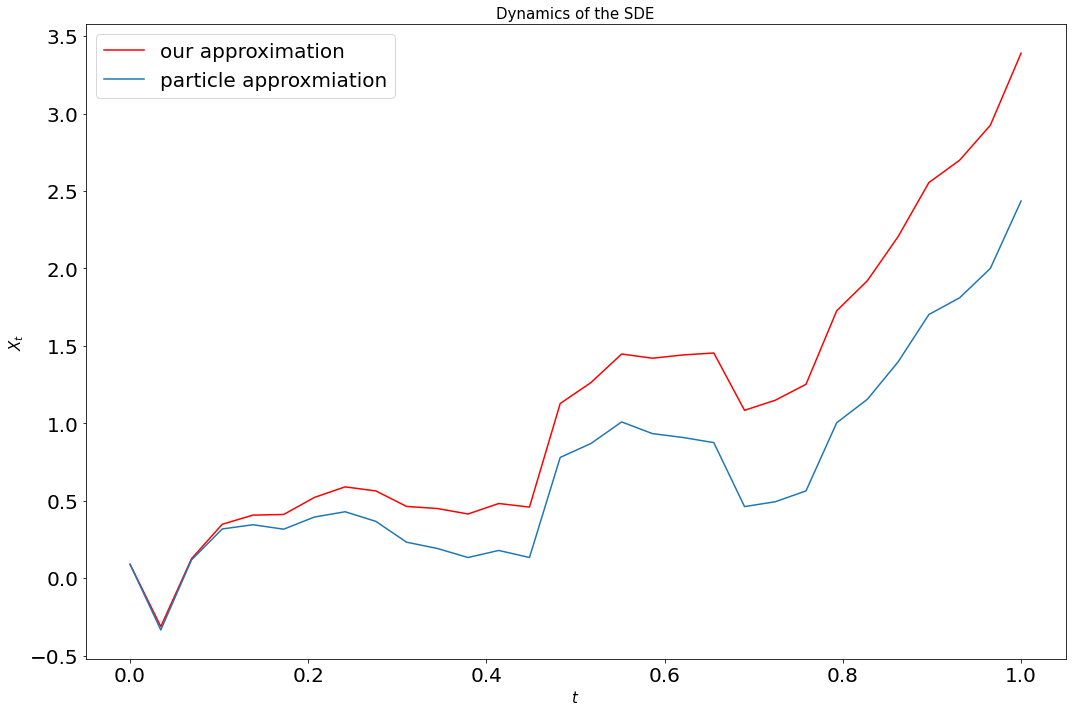

In [13]:
n_discr = 30
T = 1
dt = T / n_discr
eta = 0.01

# Initialise the starting value, starting guess for gamma and diffusion constant
x_0 = 1
sigma = 1
gamma = np.random.uniform(low = - 0.7, high = 0.7, size = (2,n_discr))
eps = 0
N_iter = 1000




In [24]:
# n_discr = 100
# n_mc = 10

# x_0 = 1
# sigma = 1

# gamma_starting = np.random.uniform(low = - 0.3, high = 0.3, size = (2,n_discr))
# gamma_ref_mc = gamma_starting
# t_0 = time.time()
# for i in range(n_mc):
#     gamma_ref = SGD_MV(n_discr = 100, eta = 0.01, gamma = gamma_starting, T = 1, eps = 0, N_iter = 100)
#     gamma_ref_mc = gamma_ref_mc * i / (i + 1) + gamma_ref * 1 / (i + 1)
#     print(f'MC step {i} completed')
# print(f'{n_mc} MC iterations time with {n_discr} grid size is: {time.time() - t_0:.{4}} s.')

## Testing the variance of $\gamma$.

In [ ]:
gamma_starting = np.random.uniform(low = - 0.3, high = 0.3, size = (2,10))
gammas = []

#eta = 0.05

for i in range(10):
    gamma_ref = SGD_MV(n_discr = 10, eta = 0.01, gamma = gamma_starting, T = 1, eps = 0, N_iter = 5000)
    #print(gamma_ref)
    gammas.append(gamma_ref)

The solution of the SGD algorithm is [[ 0.83612746  0.8479837   0.83512589  0.82100834  0.79489217  0.75916265
   0.72794816  0.69357617  0.66044198  0.61552722]
 [-0.53438775 -0.43030108 -0.32983463 -0.24953279 -0.17653255 -0.10611851
  -0.05742607 -0.01034048  0.02940627  0.07200515]].
Solved for 48.33 seconds.
The solution of the SGD algorithm is [[ 0.83681848  0.84608608  0.83066358  0.81479277  0.78994542  0.75787153
   0.73101072  0.69756334  0.66324568  0.62928805]
 [-0.53369673 -0.42242177 -0.33091355 -0.24499496 -0.17760259 -0.11602307
  -0.0592363  -0.01254748  0.03222345  0.06566526]].
Solved for 48.72 seconds.
The solution of the SGD algorithm is [[ 0.84617448  0.86280125  0.85334868  0.84030247  0.81172699  0.77813799
   0.74110889  0.7012818   0.65987817  0.61628898]
 [-0.52434073 -0.42187347 -0.3170834  -0.23278919 -0.1536746  -0.08765631
  -0.03420831  0.01600238  0.06100422  0.09199088]].
Solved for 48.28 seconds.
The solution of the SGD algorithm is [[ 0.83167513  0.8

### We safe the high discretisation gamma to compare with the gamma-s with lower ones.

In [41]:
n_discr_high = 128

gamma_starting = np.random.uniform(low = - 0.3, high = 0.3, size = (2,n_discr_high))
gamma_reference = SGD_MV(n_discr = n_discr_high, eta = 0.01, gamma = gamma_starting, T = 1, eps = 0, N_iter = 200)

10% of the iterations completed.
20% of the iterations completed.
30% of the iterations completed.
40% of the iterations completed.
50% of the iterations completed.
60% of the iterations completed.
70% of the iterations completed.
80% of the iterations completed.
90% of the iterations completed.
100% of the iterations completed.
The solution of the SGD algorithm is [[ 0.09321686  0.30334232  0.190942    0.24025591  0.24294356  0.2672524
   0.16531674  0.21989847  0.26796163  0.21491007  0.22792232  0.14261336
   0.23093074  0.17578685  0.23225924  0.1658392   0.22427267  0.18999897
   0.16091064  0.14699071  0.1975054   0.1818109   0.08576236  0.12942601
   0.1892285   0.20063506  0.12676777  0.06765806  0.09670307  0.0959002
   0.09976276  0.12270797  0.10218587  0.07654666  0.15138933  0.14286549
   0.02768928  0.10675315  0.09100958  0.07243656  0.12143172  0.02063771
  -0.0175389   0.07749185  0.08370267  0.08548912  0.0449888   0.08257667
   0.06072076  0.03681802 -0.01252726 -0.0

In [46]:
n_frequency_range = [2 ** i for i in range(2,7)] ## from 2^6 to 2

#n_discr_range = [50,20,10,5,2]

x_0 = 1
sigma = 1

n_mc = 10000

##### ToDo: Run MC 50 times and get the average of empirical averages

##### Or: Check sup for a first step, then include the second, include the others by changing the frequency;

# gamma_starting = np.random.uniform(low = - 0.5, high = 0.5, size = (2,n_discr_high))

#gamma_ref = SGD_MV(n_discr = 100, eta = 0.01, gamma = gamma_starting, T = 1, eps = 0, N_iter = 1000)

'''gamma_ref should be for high discretisation, for example n_discr = 100'''
'''we choose the grid with lower number of nods and see how this improves, the gamma is fixed from the beginning'''

gammas_freq = []

for n in n_frequency_range:
    n_discr_local = n_discr_high // n
    
    gamma_aver_mc = np.zeros((2,n_discr_local))
    
    gamma_starting_local = np.zeros((2,n_discr_local))
    gamma_starting_local[0] = gamma_starting[0][::n]
    gamma_starting_local[1] = gamma_starting[1][::n]
    
    
    '''Here two options'''
    
    ################
    ### Option 1 ###
    ################
    
#     gamma_local = np.zeros((2,n_discr_local))
#     gamma_local[0] = gamma_reference[0][::n]
#     gamma_local[1] = gamma_reference[1][::n]
    
    ################
    ### Option 2 ###
    ################
    
    gamma_local = SGD_MV(n_discr = n_discr_local, eta = 0.01, gamma = gamma_starting_local, T = 1, eps = 0, N_iter = 1000)
    gammas_freq.append(gamma_local)
    
    for i in range(n_mc):
        dW_t = simulate_dW_1d(n_discr_local,T)
        X = SDE_Kuramoto_appr(x_0, sigma, gamma_local, dW_t, T, n_discr_local)
        gamma_aver_mc[0] = gamma_aver_mc[0] * i / (i + 1) + np.sin(X.x) * 1 / (i + 1)
        gamma_aver_mc[1] = gamma_aver_mc[1] * i / (i + 1) + (-np.cos(X.x)) * 1 / (i + 1)
    print(f'The difference between MC gamma_aver and gamma_aver from the algorithm for {n_discr_local} is: \n\n{gamma_aver_mc - gamma_local}')

    print(f'\nThe maximum norm for {n_discr_local}: {abs(gamma_aver_mc - gamma_local).max()}.')
    print('\n___________________________________________________________________________________________')
    print('___________________________________________________________________________________________\n')

The solution of the SGD algorithm is [[ 0.8059639   0.8425647   0.83694496  0.82913035  0.81410457  0.8138222
   0.78817593  0.77132569  0.75251244  0.72228693  0.71535166  0.68591454
   0.66287586  0.63532742  0.62219138  0.60668825]
 [-0.50962894 -0.44242222 -0.40067975 -0.33547093 -0.26867225 -0.23330967
  -0.18357657 -0.14090137 -0.10309111 -0.06384771 -0.04623763 -0.01431414
  -0.00503375  0.04199621  0.05568742  0.07833578]].
Solved for 37.42 seconds.
The difference between MC gamma_aver and gamma_aver from the algorithm for 16 is: 

[[ 0.03550708  0.00484019  0.0098631   0.00938618  0.0147923   0.0019459
   0.01473386  0.01558953  0.01501804  0.02672431  0.01246     0.01892622
   0.01939401  0.02700218  0.01677256  0.00879206]
 [-0.03067337 -0.02862274 -0.00742964 -0.01451916 -0.03264849 -0.01926864
  -0.02518204 -0.0264803  -0.02448015 -0.03061292 -0.01622415 -0.01860533
  -0.00044222 -0.02308977 -0.01327172 -0.01389728]]

The maximum norm for 16: 0.035507080580718164.

_______

NameError: name 'length' is not defined

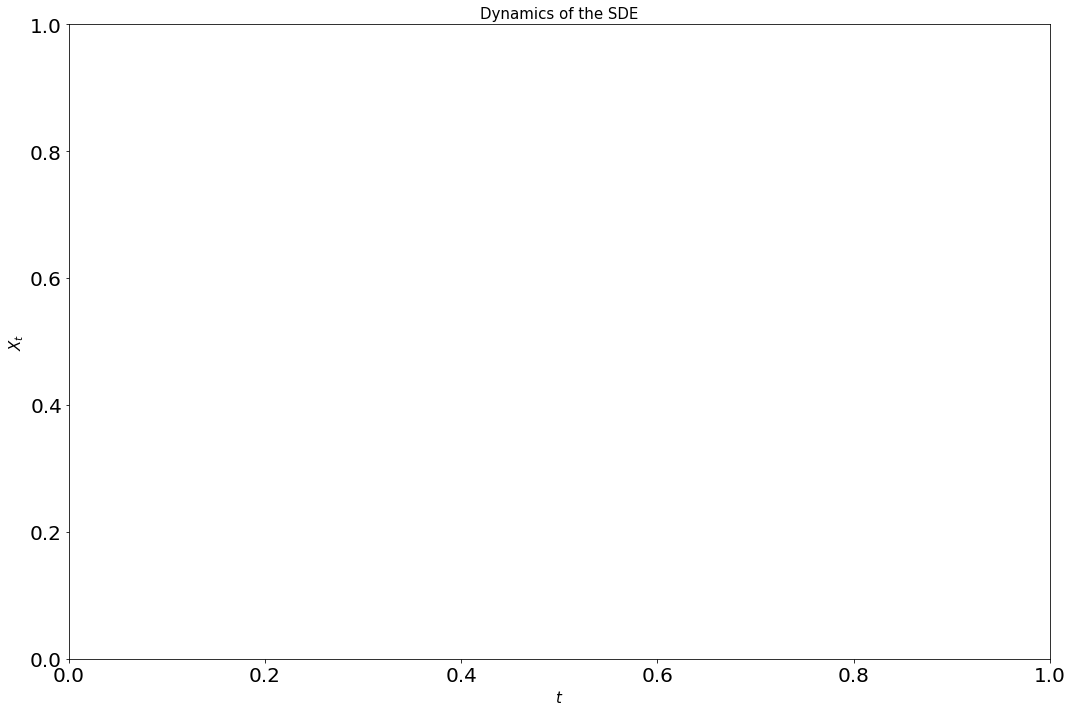

In [48]:
def transform_dW(dW_t,n_discr, n):
    dW_t_new = np.zeros(n)
    k = 0
    for i in range(dW_t.shape[0]):
        local += dW_t[i]
        if (i + 1) % n == 0:
            dW[k] = local
            local = 0
        k += 1
    return dW_t_new

n_discr = 32
n_part = 100

dW_t = simulate_dW((n_part,n_discr),T)
X_true = SDE_Kuramoto_MV(x_0, sigma, dW_t, T, n_discr, n_part)

# dW_t_truncated = dW_t[0]

t = np.linspace(0, T, n_discr)
        
fig, ax = plt.subplots(1,1,figsize=(15, 10), tight_layout=True)

ax.set_title(r"Dynamics of the SDE", fontsize = 15)
ax.set_xlabel(r'$t$',fontsize = 15)
ax.set_ylabel(r'$X_t$',fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 20)
ax.tick_params(axis='both', which='minor', labelsize = 20)

for n in range(length(n_frequency_range)):
    dW_t_local = transform_dW(dW_t,n_discr,n_frequency_range[n])
    X_test = SDE_Kuramoto_appr(X_true.x_0[0], sigma, gammas_freq[n], dW_t_local, T, n_discr_high // n_frequency_range[n])
    ax.plot(t, X_test.x, label = 'our approximation')
    
ax.plot(t, X_true.x[0],c = 'r', label = 'particle approxmiation')
plt.legend(loc='best', fontsize = 20)
plt.show()